# Imports

In [ ]:
import sys
ROOT = '../'
sys.path.append(ROOT)  # Add the root folder to the sys.path

# Import the modules
from config import *
from utils.utils import *
from shared.constants import *
from utils.pred_config import *
from utils.pred_utils import *

# Reload the configuration
from importlib import reload
reload(sys.modules['config'])
reload(sys.modules['utils.utils'])
reload(sys.modules['shared.constants'])
reload(sys.modules['utils.pred_config'])
reload(sys.modules['utils.pred_utils'])

# Import the reloaded modules
from config import *
from utils.utils import *
from shared.constants import *
from utils.pred_config import *
from utils.pred_utils import *

In [ ]:
# Setup device-agnostic code
device = select_device()

# Data preparation

In [ ]:
import pandas as pd

print(f"LLM Model: {LLM_MODEL}")

# Read the dataset
DATASET_PATH = os.path.join(ROOT, ANNOTATED_DATASET_PATH, f"merged_no_text_{DATASET_TYPE}_{LLM_MODEL}_opinion.csv")
df = pd.read_csv(DATASET_PATH)
df.head()

In [ ]:
# Print shape
print(f"Shape: {df.shape}")

In [5]:
# Remove the dataset rows where fng_sentiment, fng_value_classification and fng_value are NaN
df = df.dropna(subset=['fng_sentiment', 'fng_value_classification', 'fng_value']).reset_index(drop=True)

In [6]:
# Remove the last row because has NaN values
df = df[:-1]

In [ ]:
# Print shape
print(f"Shape: {df.shape}")

In [ ]:
# Convert the values into the categorical columns into numerical values
df['action_class'] = df['action_class'].map(action_mapping)
df['sentiment_class'] = df['sentiment_class'].map(sentiment_mapping)
df['trend'] = df['trend'].map(trend_mapping)
df['cbbi_sentiment'] = df['cbbi_sentiment'].map(sentiment_mapping)
df['fng_sentiment'] = df['fng_sentiment'].map(sentiment_mapping)

# Convert 'action_score' from float to int64
df['action_score'] = df['action_score'].astype('int64')

# Convert fng_value_classification from float to int64
df['fng_value_classification'] = df['fng_value_classification'].astype('int64')

# Start action_score from 0 instead of 1
df['action_score'] = df['action_score'] - 1
df.head()

In [9]:
# Remove the columns that refers to the future
df = df.drop(["avg_next_price", "trend"], axis=1) if TARGET_FEATURE == 'pct_price_change' else df.drop(["avg_next_price", "pct_price_change"], axis=1)

In [ ]:
# Define the target column and the target label
target_column = ['target']

continuous_features = df.select_dtypes(include=['float64']).columns.tolist()
if USE_LLM_FEATURES:
    categorical_features = df.select_dtypes(include=['int64']).columns.tolist()
else:
    categorical_features = df.select_dtypes(include=['int64']).columns.tolist()[:-3] # Remove LLM features

# Pop the target column
continuous_features.remove(TARGET_FEATURE) if TARGET_FEATURE == 'pct_price_change' else categorical_features.remove('trend')

# Print the lists   
print(f"Continuous Features {len(continuous_features)}: {continuous_features}")
print(f"Categorical Features {len(categorical_features)}: {categorical_features}")

# Sum of the lengths of the lists should be equal to the number of columns in the dataframe
print("Total continuous and categorical features: ", len(continuous_features) + len(categorical_features) + len(target_column))

In [ ]:
# Count the number of NaN values in each column
df.isna().sum()

In [ ]:
# Print columns types
print(df.dtypes)

In [ ]:
# Copy the dataframe
df_copy = df.copy()

# Add target column
df_copy[target_column[0]] = df_copy[TARGET_FEATURE]

# Drop the target column
df_copy = df_copy.drop(TARGET_FEATURE, axis=1)
df_copy.head()

In [ ]:
# Select the columns to be used
df_new = df_copy[continuous_features + categorical_features + target_column].copy() 
df_new.head()

In [ ]:
# Retrieve the split index
train_split_index = df_new[df['timestamp'] == SPLIT_DATE].index[0]
val_test_split_index = train_split_index + int((len(df_new) - train_split_index) / 2) # For validation and testing take the rest of the data and split it in half
 
# Split the data
train = df_new.iloc[:train_split_index]
validation = df_new.iloc[train_split_index:val_test_split_index]
test = df_new.iloc[val_test_split_index:]

# Define the splitting df shape
splitting_df = (len(train), len(validation), len(test))

# Print the shapes
print(splitting_df)

In [ ]:
# Scale the data
if SCALE_DATA:
    from sklearn.preprocessing import StandardScaler

    # Scale the continuous features
    scaler = StandardScaler()

    # Fit the scaler on the train set
    scaler.fit(train[continuous_features]) # Fit only the train set to prevent data leakage

    # Transform the train and test sets
    train[continuous_features] = scaler.transform(train[continuous_features])
    validation[continuous_features] = scaler.transform(validation[continuous_features])
    test[continuous_features] = scaler.transform(test[continuous_features])

    # Scale the target column if it is 'pct_price_change'
    if TARGET_FEATURE == 'pct_price_change':
        train[target_column] = scaler.fit_transform(train[target_column])
        validation[target_column] = scaler.transform(validation[target_column])
        test[target_column] = scaler.transform(test[target_column])

In [ ]:
train.tail()

In [ ]:
validation.head()

In [ ]:
validation.tail()

In [ ]:
test.head()

In [21]:
# Split the data into X and y
X_train, y_train = train.drop(target_column, axis=1), train[target_column]
X_val, y_val = validation.drop(target_column, axis=1), validation[target_column]
X_test, y_test = test.drop(target_column, axis=1), test[target_column]

In [ ]:
# Print the shapes
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape", y_test.shape)

In [ ]:
from matplotlib import pyplot as plt

# Plot the train and test sets
plt.figure(figsize=(15, 5))
plt.plot(y_train, label='Train')
plt.plot(y_val, label='Validation')
plt.plot(y_test, label='Test')
plt.title('Train, Validation and Test sets')
plt.xlabel('Days')
plt.ylabel('% Price change' if TARGET_FEATURE == 'pct_price_change' else 'Trend')
if TARGET_FEATURE != 'pct_price_change':
    plt.yticks(list(trend_mapping.values()), list(trend_mapping.keys()))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
if TARGET_FEATURE != 'pct_price_change':
    # Count the number of class for each set
    train_counts = y_train.value_counts()
    val_counts = y_val.value_counts()
    test_counts = y_test.value_counts()

    print("Train set")
    print(train_counts)
    print("Validation set")
    print(val_counts)
    print("Test set")
    print(test_counts)

    print("Total train set: ", train_counts.sum())
    print("Total validation set: ", val_counts.sum())
    print("Total test set: ", test_counts.sum())
else:
    # Count the min, max, mean and std of the target column
    train_stats = y_train.describe()
    val_stats = y_val.describe()
    test_stats = y_test.describe()

    # Approximate the values to 2 decimal places
    train_stats = train_stats.apply(lambda x: round(x, 2))
    val_stats = val_stats.apply(lambda x: round(x, 2))
    test_stats = test_stats.apply(lambda x: round(x, 2))

    # Print the statistics
    print("Train set")
    print(train_stats)
    print("Validation set")
    print(val_stats)
    print("Test set")
    print(test_stats)

In [ ]:
# Define the number of categories for each categorical feature
num_categories = {
        'fng_value_classification': 5, # 0 to 4
        'fng_sentiment': 3, # 0, 1, 2
        'cbbi_sentiment': 3 # 0, 1, 2
    }

# Add the LLM features if they are used
if USE_LLM_FEATURES:
    num_categories.update({
        'sentiment_class': 3, # 0, 1, 2
        'action_class': 3, # 0, 1, 2
        'action_score': 10 # 0 to 0
    })

print(f"Num categories: {num_categories}")

In [26]:
import torch
import torch.nn as nn

# Define the embedding layer class
class EmbeddingLayer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(EmbeddingLayer, self).__init__()
        # Take the number of features and the embedding dimension
        self.embedding = nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)
        
    def forward(self, x):
        return self.embedding(x) # Return the embedding layer 

In [ ]:
# Define the embedding dimension
num_continuous_features = len(continuous_features)
cat_emb_dim = EMB_DIM - num_continuous_features # The embedding dimension is the total dimension of the embedding minus the number of continuous features

# Create the embedding layers for each categorical feature
embedding_layers = {
        'fng_value_classification': EmbeddingLayer(num_categories['fng_value_classification'], cat_emb_dim).to(device),
        'fng_sentiment': EmbeddingLayer(num_categories['fng_sentiment'], cat_emb_dim).to(device),
        'cbbi_sentiment': EmbeddingLayer(num_categories['cbbi_sentiment'], cat_emb_dim).to(device)
    }

# Add the LLM features if they are used
if USE_LLM_FEATURES:
    embedding_layers.update({
        'sentiment_class': EmbeddingLayer(num_categories['sentiment_class'], cat_emb_dim).to(device),
        'action_class': EmbeddingLayer(num_categories['action_class'], cat_emb_dim).to(device),
        'action_score': EmbeddingLayer(num_categories['action_score'], cat_emb_dim).to(device)
    })
    
print(f"Embedding layers: {embedding_layers}")

In [28]:
from torch.utils.data import TensorDataset

# Create dataset
def create_dataset(X, y, batch_size):
    continuous_features = torch.tensor(X.drop(columns=num_categories.keys()).values, dtype=torch.float32).to(device) # Get the continuous features
    categorical_features = {key: torch.tensor(X[key].values, dtype=torch.long).to(device) for key in num_categories.keys()} # Get the categorical features
    targets = torch.tensor(y.values, dtype=torch.float32).to(device) if TARGET_FEATURE == 'pct_price_change' else torch.tensor(y.values, dtype=torch.long).to(device) # Get the targets
    
    dataset = TensorDataset(continuous_features, *categorical_features.values(), targets) # Create the dataset with all the features and the targets

    return dataset

In [29]:
from torch.utils.data import DataLoader

# Create the train and test datasets
train_dataset = create_dataset(X_train, y_train, BATCH_SIZE)
val_dataset = create_dataset(X_val, y_val, BATCH_SIZE)
test_dataset = create_dataset(X_test, y_test, BATCH_SIZE)

# Create the train and test dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Print an example batch
for cont, *cat, target in train_dataloader:
    print("Continuous features shape: ", cont.shape)
    print("Categorical features shape: ", [x.shape for x in cat])
    print("Target shape: ", target.shape)

    print("Continuous features: ", cont[:2])
    print("Categorical features: ", cat[:2])
    print("Target: ", target[:2])
    break

In [ ]:
# Initialize the model
training_total_step = len(train_dataloader)
validation_total_step = len(test_dataloader)
print(f"Training total step: {training_total_step}")
print(f"Validation total step: {validation_total_step}")

# Model training

In [ ]:
from torch import nn

# Initialize parameters
parameters = {
        'embedding_layers': embedding_layers,
        'embedding_dim': cat_emb_dim,
        'num_continuous_features': num_continuous_features,
        'output_size': OUTPUT_SIZE,
        'dropout': DROPOUT
    }

# Select model parameters
if MODEL_NAME == 'lstm_base':
    parameters['hidden_size'] = LSTM_HIDDEN_SIZE
    parameters['num_layers'] = LSTM_NUM_LAYERS
elif MODEL_NAME == 'transformer_base' or MODEL_NAME == 'autoformer' or MODEL_NAME == 'informer' or MODEL_NAME == 'prob_transformer':
    parameters['model_dim'] = TF_MODEL_DIM
    parameters['num_heads'] = TF_NUM_HEADS
    parameters['num_layers'] = TF_NUM_LAYERS
else:
    raise ValueError("Invalid model name")

# Load the model
model = select_model(MODEL_NAME, parameters).to(device)
print(model)

# Define the loss function and the optimizer
criterion = nn.MSELoss() if TARGET_FEATURE == 'pct_price_change' else nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=REG)

In [33]:
# Retrieve the metrics and the metrics list
metrics, metrics_list = initialize_metrics(TARGET_FEATURE, device)

In [34]:
# # Populate the configuration
# config = {
#     "architecture": MODEL_NAME,
#     "task": "regression" if TARGET_FEATURE == 'pct_price_change' else "classification",
#     "learning_rate": LR,
#     "epochs": EPOCHS,
#     "reg": REG,
#     "batch_size": BATCH_SIZE,
#     "output_size": OUTPUT_SIZE,
#     "embedding_layers": len(embedding_layers.keys()),
#     "embedding_dim": EMB_DIM,
#     "num_continuous_features": num_continuous_features,
#     "input_size": num_continuous_features + cat_emb_dim,
#     "dataset_type": DATASET_TYPE,
#     "use_llm_features": USE_LLM_FEATURES,
#     "optimizer": "AdamW",
#     "use_wandb": USE_WANDB,
#     "splitting_df": splitting_df,
#     "scale_data": SCALE_DATA,
#     "dropout": DROPOUT
# }

In [35]:
# from datetime import datetime

# # Definition of the parameters to create folders where to save data (plots and models)
# current_datetime = datetime.now()
# current_datetime_str = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")
# data_name = f"{MODEL_NAME}_{config['task']}_{current_datetime_str}"

# # Generate the configuration dictionary
# if MODEL_NAME == 'lstm_base':
#     config.update({
#         "hidden_size": LSTM_HIDDEN_SIZE,
#         "num_layers": LSTM_NUM_LAYERS
#     })
# elif MODEL_NAME == 'transformer_base' or MODEL_NAME == 'autoformer' or MODEL_NAME == 'informer' or MODEL_NAME == 'timeseries_transformer' or MODEL_NAME == 'prob_transformer':
#     config.update({
#         "model_dim": TF_MODEL_DIM,
#         "num_head": TF_NUM_HEADS,
#         "num_layers": TF_NUM_LAYERS
#     })
# else:
#     raise ValueError("Invalid model name")
    
# # Save configurations
# save_configurations(data_name, config)  
 
# # Use wandb
# if USE_WANDB:
#     import wandb
    
#     wandb.init(
#         project="thesis_project",
#         config=config,
#         name=data_name
#     )

In [36]:
# # Train the model
# metrics_list = train_model(
#     model,
#     MODEL_NAME, 
#     train_dataloader, 
#     val_dataloader, 
#     criterion, 
#     optimizer, 
#     metrics, 
#     metrics_list, 
#     data_name, 
#     device, 
#     EPOCHS, 
#     TARGET_FEATURE, 
#     USE_WANDB, 
#     USE_LLM_FEATURES
#     )

In [37]:
# # Plot the loss
# plot_results(metrics_list['train_loss'], metrics_list['val_loss'], title='Loss', x_label='Epoch', y_label='Loss', legend=['Train Loss', 'Validation Loss'], config=config, save_plot=False)

# # Plot the metrics
# if TARGET_FEATURE == 'pct_price_change':
#     plot_results(metrics_list['train_mse'], metrics_list['val_rmse'], title='RMSE', x_label='Epoch', y_label='RMSE', legend=['Train RMSE', 'Validation RMSE'], config=config, save_plot=False)
#     plot_results(metrics_list['train_mse'], metrics_list['val_mse'], title='MSE', x_label='Epoch', y_label='MSE', legend=['Train MSE', 'Validation MSE'], config=config, save_plot=False)
#     plot_results(metrics_list['train_mae'], metrics_list['val_mae'], title='MAE', x_label='Epoch', y_label='MAE', legend=['Train MAE', 'Validation MAE'], config=config, save_plot=False)
#     plot_results(metrics_list['train_mape'], metrics_list['val_mape'], title='MAPE', x_label='Epoch', y_label='MAPE', legend=['Train MAPE', 'Validation MAPE'], config=config, save_plot=False)
#     plot_results(metrics_list['train_r2'], metrics_list['val_r2'], title='R2', x_label='Epoch', y_label='R2', legend=['Train R2', 'Validation R2'], config=config, save_plot=False)
# else:
#     plot_results(metrics_list['train_accuracy'], metrics_list['val_accuracy'], title='Accuracy', x_label='Epoch', y_label='Accuracy', legend=['Train Accuracy', 'Validation Accuracy'], config=config, save_plot=False)
#     plot_results(metrics_list['train_precision'], metrics_list['val_precision'], title='Precision', x_label='Epoch', y_label='Precision', legend=['Train Precision', 'Validation Precision'], config=config, save_plot=False)
#     plot_results(metrics_list['train_recall'], metrics_list['val_recall'], title='Recall', x_label='Epoch', y_label='Recall', legend=['Train Recall', 'Validation Recall'], config=config, save_plot=False)
#     plot_results(metrics_list['train_f1'], metrics_list['val_f1'], title='F1', x_label='Epoch', y_label='F1', legend=['Train F1', 'Validation F1'], config=config, save_plot=False)
#     plot_results(metrics_list['train_auroc'], metrics_list['val_auroc'], title='ROC AUC', x_label='Epoch', y_label='ROC AUC', legend=['Train ROC AUC', 'Validation ROC AUC'], config=config, save_plot=False)

# Model predictions

In [ ]:
# Make predictions on the training and test sets
test_total_step = len(test_dataloader)
slot = [500]

# Define the model path
# ['lstm_base_classification_2024-09-24_16-39-00', 'transformer_base_classification_2024-09-24_16-41-56']
# ['lstm_base_regression_2024-09-24_16-23-22', 'transformer_base_regression_2024-09-24_16-33-47']
data_name = "transformer_base_regression_2024-09-24_16-33-47"
model_path = f"checkpoints/{data_name}"
print(data_name)

# Load configurations from json file
config_path = f"{model_path}/config.json"
with open(config_path, 'r') as file:
    config = json.load(file)

for s in slot: 
    full_model_path = f"{model_path}/models/checkpoint_{s}.pt"
    model = torch.load(full_model_path)  
    print(f"Epoch: {s}")

    # Make predictions
    train_predictions, test_predictions = make_predictions(
        model, 
        MODEL_NAME, 
        train_dataloader, 
        test_dataloader, 
        criterion, 
        metrics, 
        data_name, 
        device, 
        TARGET_FEATURE, 
        USE_WANDB, 
        USE_LLM_FEATURES
        )

## Classification

### LSTM

In [39]:
# Epoch: 50
# Train Loss: 0.8727, TEST_ACCURACY: 61.8661, TEST_PRECISION: 38.0501, TEST_RECALL: 46.8874, TEST_F1: 41.9029
# Test Loss: 0.9389, TEST_ACCURACY: 60.6557, TEST_PRECISION: 34.1212, TEST_RECALL: 38.6111, TEST_F1: 36.0386
# Epoch: 100
# Train Loss: 0.8300, TEST_ACCURACY: 62.8296, TEST_PRECISION: 38.9466, TEST_RECALL: 46.1867, TEST_F1: 41.7179
# Test Loss: 1.0247, TEST_ACCURACY: 56.8306, TEST_PRECISION: 33.8801, TEST_RECALL: 41.8519, TEST_F1: 36.9859
# Epoch: 150
# Train Loss: 0.8307, TEST_ACCURACY: 63.8945, TEST_PRECISION: 39.6686, TEST_RECALL: 51.1593, TEST_F1: 44.5913
# Test Loss: 1.0520, TEST_ACCURACY: 57.9235, TEST_PRECISION: 33.0107, TEST_RECALL: 39.1667, TEST_F1: 35.8008
# Epoch: 200
# Train Loss: 0.7818, TEST_ACCURACY: 64.9594, TEST_PRECISION: 42.2758, TEST_RECALL: 47.0544, TEST_F1: 43.0960
# Test Loss: 1.1223, TEST_ACCURACY: 59.0164, TEST_PRECISION: 30.2232, TEST_RECALL: 34.5370, TEST_F1: 31.8035
# Epoch: 250
# Train Loss: 0.7653, TEST_ACCURACY: 66.2779, TEST_PRECISION: 41.3500, TEST_RECALL: 52.8351, TEST_F1: 46.3713
# Test Loss: 1.1970, TEST_ACCURACY: 55.7377, TEST_PRECISION: 33.1451, TEST_RECALL: 40.6481, TEST_F1: 35.8187
# Epoch: 300
# Train Loss: 0.7756, TEST_ACCURACY: 65.3144, TEST_PRECISION: 40.6656, TEST_RECALL: 52.5710, TEST_F1: 45.7398
# Test Loss: 1.4554, TEST_ACCURACY: 53.5519, TEST_PRECISION: 30.3806, TEST_RECALL: 36.2963, TEST_F1: 32.8170
# Epoch: 350
# Train Loss: 0.8141, TEST_ACCURACY: 62.9817, TEST_PRECISION: 49.9917, TEST_RECALL: 54.1806, TEST_F1: 47.1759
# Test Loss: 1.2905, TEST_ACCURACY: 59.5628, TEST_PRECISION: 44.6809, TEST_RECALL: 39.6605, TEST_F1: 38.0434
# Epoch: 400
# Train Loss: 0.7331, TEST_ACCURACY: 64.9594, TEST_PRECISION: 50.5571, TEST_RECALL: 55.6841, TEST_F1: 50.6573
# Test Loss: 1.6288, TEST_ACCURACY: 54.0984, TEST_PRECISION: 48.6499, TEST_RECALL: 40.4321, TEST_F1: 38.3478
# Epoch: 450
# Train Loss: 0.7519, TEST_ACCURACY: 66.5314, TEST_PRECISION: 62.0317, TEST_RECALL: 49.5200, TEST_F1: 49.7022
# Test Loss: 1.3037, TEST_ACCURACY: 61.2022, TEST_PRECISION: 43.2300, TEST_RECALL: 38.8580, TEST_F1: 38.4764
# Epoch: 500
# Train Loss: 0.8267, TEST_ACCURACY: 66.3793, TEST_PRECISION: 68.1380, TEST_RECALL: 48.5934, TEST_F1: 48.5928
# Test Loss: 1.5320, TEST_ACCURACY: 60.1093, TEST_PRECISION: 41.8129, TEST_RECALL: 36.0494, TEST_F1: 34.5139

In [40]:
# Considering the balance of test loss and test F1-score, Epoch 450 seems to be the best performing checkpoint, as it provides the best overall test accuracy and F1-score, despite having a slightly higher test loss.

### Transformer

In [41]:
# Epoch: 50
# Train Loss: 0.9698, TEST_ACCURACY: 52.8905, TEST_PRECISION: 46.1326, TEST_RECALL: 46.1954, TEST_F1: 46.0793
# Test Loss: 0.8717, TEST_ACCURACY: 65.5738, TEST_PRECISION: 21.8579, TEST_RECALL: 33.3333, TEST_F1: 26.4026
# Epoch: 100
# Train Loss: 0.7557, TEST_ACCURACY: 65.7708, TEST_PRECISION: 60.8375, TEST_RECALL: 54.5138, TEST_F1: 56.1113
# Test Loss: 0.9676, TEST_ACCURACY: 64.4809, TEST_PRECISION: 33.1418, TEST_RECALL: 34.7222, TEST_F1: 30.5215
# Epoch: 150
# Train Loss: 0.6181, TEST_ACCURACY: 71.8053, TEST_PRECISION: 68.7651, TEST_RECALL: 63.5114, TEST_F1: 65.3617
# Test Loss: 1.0114, TEST_ACCURACY: 65.0273, TEST_PRECISION: 30.6190, TEST_RECALL: 34.3519, TEST_F1: 29.4710
# Epoch: 200
# Train Loss: 0.5229, TEST_ACCURACY: 76.0649, TEST_PRECISION: 72.6601, TEST_RECALL: 70.8706, TEST_F1: 71.6091
# Test Loss: 1.0978, TEST_ACCURACY: 62.8415, TEST_PRECISION: 33.4003, TEST_RECALL: 34.5370, TEST_F1: 31.4297
# Epoch: 250
# Train Loss: 0.4789, TEST_ACCURACY: 79.3103, TEST_PRECISION: 76.5910, TEST_RECALL: 75.0793, TEST_F1: 75.6470
# Test Loss: 1.0835, TEST_ACCURACY: 59.5628, TEST_PRECISION: 28.7473, TEST_RECALL: 33.5185, TEST_F1: 30.4946
# Epoch: 300
# Train Loss: 0.4082, TEST_ACCURACY: 83.3671, TEST_PRECISION: 80.8758, TEST_RECALL: 81.0709, TEST_F1: 80.9512
# Test Loss: 1.2971, TEST_ACCURACY: 62.8415, TEST_PRECISION: 27.9598, TEST_RECALL: 33.2407, TEST_F1: 28.6360
# Epoch: 350
# Train Loss: 0.3717, TEST_ACCURACY: 83.6207, TEST_PRECISION: 82.9984, TEST_RECALL: 78.6147, TEST_F1: 80.4375
# Test Loss: 1.5099, TEST_ACCURACY: 64.4809, TEST_PRECISION: 51.1320, TEST_RECALL: 35.6790, TEST_F1: 32.7829
# Epoch: 400
# Train Loss: 0.3557, TEST_ACCURACY: 87.2211, TEST_PRECISION: 85.8510, TEST_RECALL: 84.5056, TEST_F1: 85.1444
# Test Loss: 1.3326, TEST_ACCURACY: 61.2022, TEST_PRECISION: 48.2222, TEST_RECALL: 36.6049, TEST_F1: 35.0699
# Epoch: 450
# Train Loss: 0.3191, TEST_ACCURACY: 87.6268, TEST_PRECISION: 85.9976, TEST_RECALL: 85.2051, TEST_F1: 85.4475
# Test Loss: 1.2117, TEST_ACCURACY: 57.9235, TEST_PRECISION: 38.8889, TEST_RECALL: 33.6420, TEST_F1: 31.9641
# Epoch: 500
# Train Loss: 0.3346, TEST_ACCURACY: 86.3590, TEST_PRECISION: 84.1803, TEST_RECALL: 85.4945, TEST_F1: 84.6375
# Test Loss: 1.1886, TEST_ACCURACY: 59.0164, TEST_PRECISION: 40.3108, TEST_RECALL: 37.4383, TEST_F1: 36.0352

In [42]:
# Based on the F1 score, Epoch 500 is the best, as it has the highest F1 score, meaning the model is best at balancing precision and recall at this point, which is particularly useful for imbalanced datasets or tasks where both false positives and false negatives are important.

## Regression

### LSTM

In [43]:
# Epoch: 50
# Train Loss: 0.7882, TEST_RMSE: 0.7916, TEST_MSE: 0.8897, TEST_MAE: 0.6383, TEST_MAPE: 4.3567, TEST_R2: 0.2084
# Test Loss: 0.5766, TEST_RMSE: 0.5877, TEST_MSE: 0.7666, TEST_MAE: 0.5813, TEST_MAPE: 2.5645, TEST_R2: -0.1063
# Epoch: 100
# Train Loss: 0.7973, TEST_RMSE: 0.8007, TEST_MSE: 0.8948, TEST_MAE: 0.6560, TEST_MAPE: 5.5217, TEST_R2: 0.1993
# Test Loss: 0.6609, TEST_RMSE: 0.6745, TEST_MSE: 0.8213, TEST_MAE: 0.6310, TEST_MAPE: 2.6436, TEST_R2: -0.2697
# Epoch: 150
# Train Loss: 0.6047, TEST_RMSE: 0.6073, TEST_MSE: 0.7793, TEST_MAE: 0.5624, TEST_MAPE: 3.7488, TEST_R2: 0.3927
# Test Loss: 0.5900, TEST_RMSE: 0.6000, TEST_MSE: 0.7746, TEST_MAE: 0.5847, TEST_MAPE: 3.0976, TEST_R2: -0.1296
# Epoch: 200
# Train Loss: 0.6423, TEST_RMSE: 0.6451, TEST_MSE: 0.8032, TEST_MAE: 0.5870, TEST_MAPE: 5.1326, TEST_R2: 0.3549
# Test Loss: 0.8909, TEST_RMSE: 0.9115, TEST_MSE: 0.9547, TEST_MAE: 0.7152, TEST_MAPE: 3.5046, TEST_R2: -0.7160
# Epoch: 250
# Train Loss: 0.5238, TEST_RMSE: 0.5259, TEST_MSE: 0.7252, TEST_MAE: 0.5235, TEST_MAPE: 4.5554, TEST_R2: 0.4741
# Test Loss: 1.0153, TEST_RMSE: 1.0330, TEST_MSE: 1.0164, TEST_MAE: 0.7783, TEST_MAPE: 3.8390, TEST_R2: -0.9447
# Epoch: 300
# Train Loss: 0.6294, TEST_RMSE: 0.6322, TEST_MSE: 0.7951, TEST_MAE: 0.6101, TEST_MAPE: 6.7199, TEST_R2: 0.3678
# Test Loss: 0.9123, TEST_RMSE: 0.9243, TEST_MSE: 0.9614, TEST_MAE: 0.7438, TEST_MAPE: 4.6693, TEST_R2: -0.7400
# Epoch: 350
# Train Loss: 0.5106, TEST_RMSE: 0.5128, TEST_MSE: 0.7161, TEST_MAE: 0.5246, TEST_MAPE: 5.6765, TEST_R2: 0.4872
# Test Loss: 1.2111, TEST_RMSE: 1.2332, TEST_MSE: 1.1105, TEST_MAE: 0.8796, TEST_MAPE: 4.5435, TEST_R2: -1.3217
# Epoch: 400
# Train Loss: 0.6198, TEST_RMSE: 0.6225, TEST_MSE: 0.7890, TEST_MAE: 0.5953, TEST_MAPE: 6.2501, TEST_R2: 0.3775
# Test Loss: 0.9537, TEST_RMSE: 0.9693, TEST_MSE: 0.9846, TEST_MAE: 0.7689, TEST_MAPE: 4.6526, TEST_R2: -0.8248
# Epoch: 450
# Train Loss: 0.5240, TEST_RMSE: 0.5263, TEST_MSE: 0.7254, TEST_MAE: 0.5406, TEST_MAPE: 5.1444, TEST_R2: 0.4737
# Test Loss: 1.0152, TEST_RMSE: 1.0313, TEST_MSE: 1.0155, TEST_MAE: 0.7974, TEST_MAPE: 5.6001, TEST_R2: -0.9415
# Epoch: 500
# Train Loss: 0.5566, TEST_RMSE: 0.5590, TEST_MSE: 0.7477, TEST_MAE: 0.5608, TEST_MAPE: 6.2906, TEST_R2: 0.4410
# Test Loss: 1.1487, TEST_RMSE: 1.1691, TEST_MSE: 1.0813, TEST_MAE: 0.8737, TEST_MAPE: 5.3529, TEST_R2: -1.2010

In [44]:
# The best epoch is Epoch 250, as it has the lowest Test Loss and TEST_RMSE, indicating the best generalization performance on the test set.

### Transformer

In [45]:
# Epoch: 50
# Train Loss: 0.9665, TEST_RMSE: 0.9704, TEST_MSE: 0.9851, TEST_MAE: 0.6745, TEST_MAPE: 2.3377, TEST_R2: 0.0296
# Test Loss: 0.5263, TEST_RMSE: 0.5367, TEST_MSE: 0.7326, TEST_MAE: 0.5351, TEST_MAPE: 1.4255, TEST_R2: -0.0104
# Epoch: 100
# Train Loss: 0.8544, TEST_RMSE: 0.8576, TEST_MSE: 0.9261, TEST_MAE: 0.6452, TEST_MAPE: 3.0079, TEST_R2: 0.1424
# Test Loss: 0.5268, TEST_RMSE: 0.5366, TEST_MSE: 0.7326, TEST_MAE: 0.5423, TEST_MAPE: 1.6200, TEST_R2: -0.0102
# Epoch: 150
# Train Loss: 0.7575, TEST_RMSE: 0.7601, TEST_MSE: 0.8718, TEST_MAE: 0.6182, TEST_MAPE: 3.5506, TEST_R2: 0.2399
# Test Loss: 0.5524, TEST_RMSE: 0.5625, TEST_MSE: 0.7500, TEST_MAE: 0.5625, TEST_MAPE: 2.0091, TEST_R2: -0.0589
# Epoch: 200
# Train Loss: 0.7015, TEST_RMSE: 0.7039, TEST_MSE: 0.8390, TEST_MAE: 0.6031, TEST_MAPE: 3.1753, TEST_R2: 0.2961
# Test Loss: 0.5562, TEST_RMSE: 0.5648, TEST_MSE: 0.7515, TEST_MAE: 0.5680, TEST_MAPE: 2.3517, TEST_R2: -0.0632
# Epoch: 250
# Train Loss: 0.6150, TEST_RMSE: 0.6169, TEST_MSE: 0.7854, TEST_MAE: 0.5699, TEST_MAPE: 4.3926, TEST_R2: 0.3831
# Test Loss: 0.6251, TEST_RMSE: 0.6354, TEST_MSE: 0.7972, TEST_MAE: 0.6146, TEST_MAPE: 3.4085, TEST_R2: -0.1963
# Epoch: 300
# Train Loss: 0.5360, TEST_RMSE: 0.5375, TEST_MSE: 0.7331, TEST_MAE: 0.5439, TEST_MAPE: 4.0942, TEST_R2: 0.4625
# Test Loss: 0.5392, TEST_RMSE: 0.5497, TEST_MSE: 0.7414, TEST_MAE: 0.5721, TEST_MAPE: 2.3487, TEST_R2: -0.0348
# Epoch: 350
# Train Loss: 0.4972, TEST_RMSE: 0.4983, TEST_MSE: 0.7059, TEST_MAE: 0.5313, TEST_MAPE: 4.5485, TEST_R2: 0.5017
# Test Loss: 0.6032, TEST_RMSE: 0.6121, TEST_MSE: 0.7823, TEST_MAE: 0.6093, TEST_MAPE: 3.6898, TEST_R2: -0.1522
# Epoch: 400
# Train Loss: 0.4514, TEST_RMSE: 0.4524, TEST_MSE: 0.6726, TEST_MAE: 0.5046, TEST_MAPE: 5.5495, TEST_R2: 0.5476
# Test Loss: 0.6013, TEST_RMSE: 0.6158, TEST_MSE: 0.7848, TEST_MAE: 0.5950, TEST_MAPE: 2.8885, TEST_R2: -0.1594
# Epoch: 450
# Train Loss: 0.4768, TEST_RMSE: 0.4780, TEST_MSE: 0.6913, TEST_MAE: 0.5133, TEST_MAPE: 4.0047, TEST_R2: 0.5220
# Test Loss: 0.5637, TEST_RMSE: 0.5768, TEST_MSE: 0.7595, TEST_MAE: 0.5600, TEST_MAPE: 2.5295, TEST_R2: -0.0859
# Epoch: 500
# Train Loss: 0.4288, TEST_RMSE: 0.4297, TEST_MSE: 0.6555, TEST_MAE: 0.4931, TEST_MAPE: 4.4862, TEST_R2: 0.5703
# Test Loss: 0.6417, TEST_RMSE: 0.6543, TEST_MSE: 0.8089, TEST_MAE: 0.6064, TEST_MAPE: 4.3086, TEST_R2: -0.2318

In [46]:
# The best epoch overall based on both Test Loss and Test RMSE is Epoch 500, as both values are the lowest at this epoch.

# Plot results

In [47]:
if TARGET_FEATURE == 'pct_price_change':
    # Unscale the predictions
    train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1)).flatten()
    test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

    # Unscale the target values
    y_train_copy = scaler.inverse_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test_copy = scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()
else:
    y_train_copy = y_train
    y_test_copy = y_test

In [ ]:
# Check the len of the predictions and the target values
print("Train predictions length: ", len(train_predictions))
print("Train target values length: ", len(y_train_copy))
print("Test predictions length: ", len(test_predictions))
print("Test target values length: ", len(y_test_copy))

In [ ]:
if TARGET_FEATURE == 'pct_price_change':
    plot_results(y_train_copy, train_predictions, title=f'Train and Validation Set Predictions (Epoch {slot[0]})', x_label='Days', y_label='% Price Change', legend=['True', 'Predicted'], config=config, save_plot=True)
    plot_results(y_test_copy, test_predictions, title=f'Test Set Predictions (Epoch {slot[0]})', x_label='Days', y_label='% Price Change', legend=['True', 'Predicted'], config=config, save_plot=True)
else:
    plot_confusion_matrix(y_train_copy, train_predictions, title=f'Train and Validation Set Predictions (Epoch {slot[0]})', x_label='Predicted', y_label='True', config=config, save_plot=True)
    plot_confusion_matrix(y_test_copy, test_predictions, title=f'Test Set Predictions (Epoch {slot[0]})', x_label='Predicted', y_label='True', config=config, save_plot=True)

In [ ]:
1=a

# General plots

In [3]:
import sys
import os
import json
from matplotlib import pyplot as plt

In [4]:
ROOT = '../'
sys.path.append(ROOT)  # Add the root folder to the sys.path

# Import the modules
from config import *

# Reload the configuration
from importlib import reload
reload(sys.modules['config'])

# Import the reloaded modules
from config import *

In [5]:
# Load models configuration and results (first LSTM and then Transformer)
# ['lstm_base_classification_2024-09-24_16-39-00', 'transformer_base_classification_2024-09-24_16-41-56']
# ['lstm_base_regression_2024-09-24_16-23-22', 'transformer_base_regression_2024-09-24_16-33-47']
models = ['lstm_base_regression_2024-09-24_16-23-22', 'transformer_base_regression_2024-09-24_16-33-47']

In [6]:
path = os.path.join(ROOT, DATA_PREDICTIONS_PATH, 'checkpoints')
def load_files(data_name):
    config_file_path = os.path.join(path, data_name, 'config.json')
    tr_val_results_file_path = os.path.join(path, data_name, 'results', 'tr_val_results.json')
    test_results_file_path = os.path.join(path, data_name, 'results', 'test_results.json')
    # Load the configuration
    with open(config_file_path, 'r') as json_file:
        configurations = json.load(json_file)

    # Load the train results
    with open(tr_val_results_file_path, 'r') as json_file:
        train_results = json.load(json_file)

    # Load the test results
    with open(test_results_file_path, 'r') as json_file:
        test_results = json.load(json_file)
    
    return configurations, train_results, test_results

In [7]:
# Inside each folder there are the configurations (config.hson) and the results (results/tr_val_results.json and results/test_results.json)

# Load the configurations and the results
configs, train_results, test_results = {}, {}, {}

for model in models:
    config, tr_val_result, test_result = load_files(model)
    configs[model] = config
    train_results[model] = tr_val_result
    test_results[model] = test_result

# Print the configurations
for model, config in configs.items():
    print(f"Model: {model}")
    print(config)
    print()

# Print the train/validation results
for model, results in train_results.items():
    print(f"Model: {model}")
    print(results)
    print()

# Print the test results
for model, results in test_results.items():
    print(f"Model: {model}")
    print(results)
    print()
    

Model: lstm_base_regression_2024-09-24_16-23-22
{'architecture': 'lstm_base', 'task': 'regression', 'learning_rate': 0.001, 'epochs': 500, 'reg': 0.001, 'batch_size': 64, 'output_size': 1, 'embedding_layers': 6, 'embedding_dim': 64, 'num_continuous_features': 21, 'input_size': 64, 'dataset_type': 'daily', 'use_llm_features': True, 'optimizer': 'AdamW', 'use_wandb': False, 'splitting_df': [1972, 183, 183], 'scale_data': True, 'dropout': 0.2, 'hidden_size': 128, 'num_layers': 4}

Model: transformer_base_regression_2024-09-24_16-33-47
{'architecture': 'transformer_base', 'task': 'regression', 'learning_rate': 0.001, 'epochs': 500, 'reg': 0.001, 'batch_size': 64, 'output_size': 1, 'embedding_layers': 6, 'embedding_dim': 64, 'num_continuous_features': 21, 'input_size': 64, 'dataset_type': 'daily', 'use_llm_features': True, 'optimizer': 'AdamW', 'use_wandb': False, 'splitting_df': [1972, 183, 183], 'scale_data': True, 'dropout': 0.2, 'model_dim': 128, 'num_head': 8, 'num_layers': 4}

Model: 

In [8]:
# Retrieve configurations (they are the same for both models)
batch_size = configs[models[0]]['batch_size']
epochs = configs[models[0]]['epochs']
lr = configs[models[0]]['learning_rate']
reg = configs[models[0]]['reg']
dropout = configs[models[0]]['dropout']
task = configs[models[0]]['task']

# Print configurations
print(f"Batch size: {batch_size}")
print(f"Epochs: {epochs}")
print(f"Learning rate: {lr}")
print(f"Regularization: {reg}")
print(f"Dropout: {dropout}")
print(f"Task: {task}")

Batch size: 64
Epochs: 500
Learning rate: 0.001
Regularization: 0.001
Dropout: 0.2
Task: regression


In [9]:
lstm_train_loss, lstm_val_loss, transformer_train_loss, transformer_val_loss = [], [], [], []
# Retrieve losses
# Assuming `train_results` is a dictionary where each model stores epoch-wise training results
lstm_train_loss = [train_results[models[0]][i]['training_loss'] for i in range(epochs)]
lstm_val_loss = [train_results[models[0]][i]['validation_loss'] for i in range(epochs)]
transformer_train_loss = [train_results[models[1]][i]['training_loss'] for i in range(epochs)]
transformer_val_loss = [train_results[models[1]][i]['validation_loss'] for i in range(epochs)]

In [10]:
# Retrieve metrics
if task == 'classification':
    lstm_train_accuracy, lstm_val_accuracy, lstm_test_accuracy = [], [], []
    lstm_train_precision, lstm_val_precision, lstm_test_precision = [], [], []
    lstm_train_recall, lstm_val_recall, lstm_test_recall = [], [], []
    lstm_train_f1, lstm_val_f1, lstm_test_f1 = [], [], []
    lstm_train_auroc, lstm_val_auroc, lstm_test_auroc = [], [], []

    lstm_train_accuracy = [train_results[models[0]][i]['training_accuracy'] for i in range(epochs)]
    lstm_val_accuracy = [train_results[models[0]][i]['validation_accuracy'] for i in range(epochs)]
    lstm_test_accuracy = test_results[models[0]][0]['test_accuracy']
    lstm_train_precision = [train_results[models[0]][i]['training_precision'] for i in range(epochs)]
    lstm_val_precision = [train_results[models[0]][i]['validation_precision'] for i in range(epochs)]
    lstm_test_precision = test_results[models[0]][0]['test_precision']
    lstm_train_recall = [train_results[models[0]][i]['training_recall'] for i in range(epochs)]
    lstm_val_recall = [train_results[models[0]][i]['validation_recall'] for i in range(epochs)]
    lstm_test_recall = test_results[models[0]][0]['test_recall']
    lstm_train_f1 = [train_results[models[0]][i]['training_f1'] for i in range(epochs)]
    lstm_val_f1 = [train_results[models[0]][i]['validation_f1'] for i in range(epochs)]
    lstm_test_f1 = test_results[models[0]][0]['test_f1']
    lstm_train_auroc = [train_results[models[0]][i]['training_auroc'] for i in range(epochs)]
    lstm_val_auroc = [train_results[models[0]][i]['validation_auroc'] for i in range(epochs)]

    transformer_train_accuracy, transformer_val_accuracy, transformer_test_accuracy = [], [], []
    transformer_train_precision, transformer_val_precision, transformer_test_precision = [], [], []
    transformer_train_recall, transformer_val_recall, transformer_test_recall = [], [], []
    transformer_train_f1, transformer_val_f1, transformer_test_f1 = [], [], []
    transformer_train_auroc, transformer_val_auroc, transformer_test_auroc = [], [], []

    transformer_train_accuracy = [train_results[models[1]][i]['training_accuracy'] for i in range(epochs)]
    transformer_val_accuracy = [train_results[models[1]][i]['validation_accuracy'] for i in range(epochs)]
    transformer_test_accuracy = test_results[models[1]][0]['test_accuracy']
    transformer_train_precision = [train_results[models[1]][i]['training_precision'] for i in range(epochs)]
    transformer_val_precision = [train_results[models[1]][i]['validation_precision'] for i in range(epochs)]
    transformer_test_precision = test_results[models[1]][0]['test_precision']
    transformer_train_recall = [train_results[models[1]][i]['training_recall'] for i in range(epochs)]
    transformer_val_recall = [train_results[models[1]][i]['validation_recall'] for i in range(epochs)]
    transformer_test_recall = test_results[models[1]][0]['test_recall']
    transformer_train_f1 = [train_results[models[1]][i]['training_f1'] for i in range(epochs)]
    transformer_val_f1 = [train_results[models[1]][i]['validation_f1'] for i in range(epochs)]
    transformer_test_f1 = test_results[models[1]][0]['test_f1']
    transformer_train_auroc = [train_results[models[1]][i]['training_auroc'] for i in range(epochs)]
    transformer_val_auroc = [train_results[models[1]][i]['validation_auroc'] for i in range(epochs)]
else:
    lstm_train_mse, lstm_val_mse, lstm_test_mse = [], [], []
    lstm_train_rmse, lstm_val_rmse, lstm_test_rmse = [], [], []
    lstm_train_mae, lstm_val_mae, lstm_test_mae = [], [], []
    lstm_train_mape, lstm_val_mape, lstm_test_mape = [], [], []
    lstm_train_r2, lstm_val_r2, lstm_test_r2 = [], [], []
   
    lstm_train_mse = [train_results[models[0]][i]['training_mse'] for i in range(epochs)]
    lstm_val_mse = [train_results[models[0]][i]['validation_mse'] for i in range(epochs)]
    lstm_test_mse = test_results[models[0]][0]['test_mse']
    lstm_train_rmse = [train_results[models[0]][i]['training_rmse'] for i in range(epochs)]
    lstm_val_rmse = [train_results[models[0]][i]['validation_rmse'] for i in range(epochs)]
    lstm_test_rmse = test_results[models[0]][0]['test_rmse']
    lstm_train_mae = [train_results[models[0]][i]['training_mae'] for i in range(epochs)]
    lstm_val_mae = [train_results[models[0]][i]['validation_mae'] for i in range(epochs)]
    lstm_test_mae = test_results[models[0]][0]['test_mae']
    lstm_train_mape = [train_results[models[0]][i]['training_mape'] for i in range(epochs)]
    lstm_val_mape = [train_results[models[0]][i]['validation_mape'] for i in range(epochs)]
    lstm_test_mape = test_results[models[0]][0]['test_mape']
    lstm_train_r2 = [train_results[models[0]][i]['training_r2'] for i in range(epochs)]
    lstm_val_r2 = [train_results[models[0]][i]['validation_r2'] for i in range(epochs)]
    lstm_test_r2 = test_results[models[0]][0]['test_r2']
   
    transformer_train_mse, transformer_val_mse, transformer_test_mse = [], [], []
    transformer_train_rmse, transformer_val_rmse, transformer_test_rmse = [], [], []
    transformer_train_mae, transformer_val_mae, transformer_test_mae = [], [], []
    transformer_train_mape, transformer_val_mape, transformer_test_mape = [], [], []
    transformer_train_r2, transformer_val_r2, transformer_test_r2 = [], [], []

    transformer_train_mse = [train_results[models[1]][i]['training_mse'] for i in range(epochs)]
    transformer_val_mse = [train_results[models[1]][i]['validation_mse'] for i in range(epochs)]
    transformer_test_mse = test_results[models[1]][0]['test_mse']
    transformer_train_rmse = [train_results[models[1]][i]['training_rmse'] for i in range(epochs)]
    transformer_val_rmse = [train_results[models[1]][i]['validation_rmse'] for i in range(epochs)]
    transformer_test_rmse = test_results[models[1]][0]['test_rmse']
    transformer_train_mae = [train_results[models[1]][i]['training_mae'] for i in range(epochs)]
    transformer_val_mae = [train_results[models[1]][i]['validation_mae'] for i in range(epochs)]
    transformer_test_mae = test_results[models[1]][0]['test_mae']
    transformer_train_mape = [train_results[models[1]][i]['training_mape'] for i in range(epochs)]
    transformer_val_mape = [train_results[models[1]][i]['validation_mape'] for i in range(epochs)]
    transformer_test_mape = test_results[models[1]][0]['test_mape']
    transformer_train_r2 = [train_results[models[1]][i]['training_r2'] for i in range(epochs)]
    transformer_val_r2 = [train_results[models[1]][i]['validation_r2'] for i in range(epochs)]
    transformer_test_r2 = test_results[models[1]][0]['test_r2']

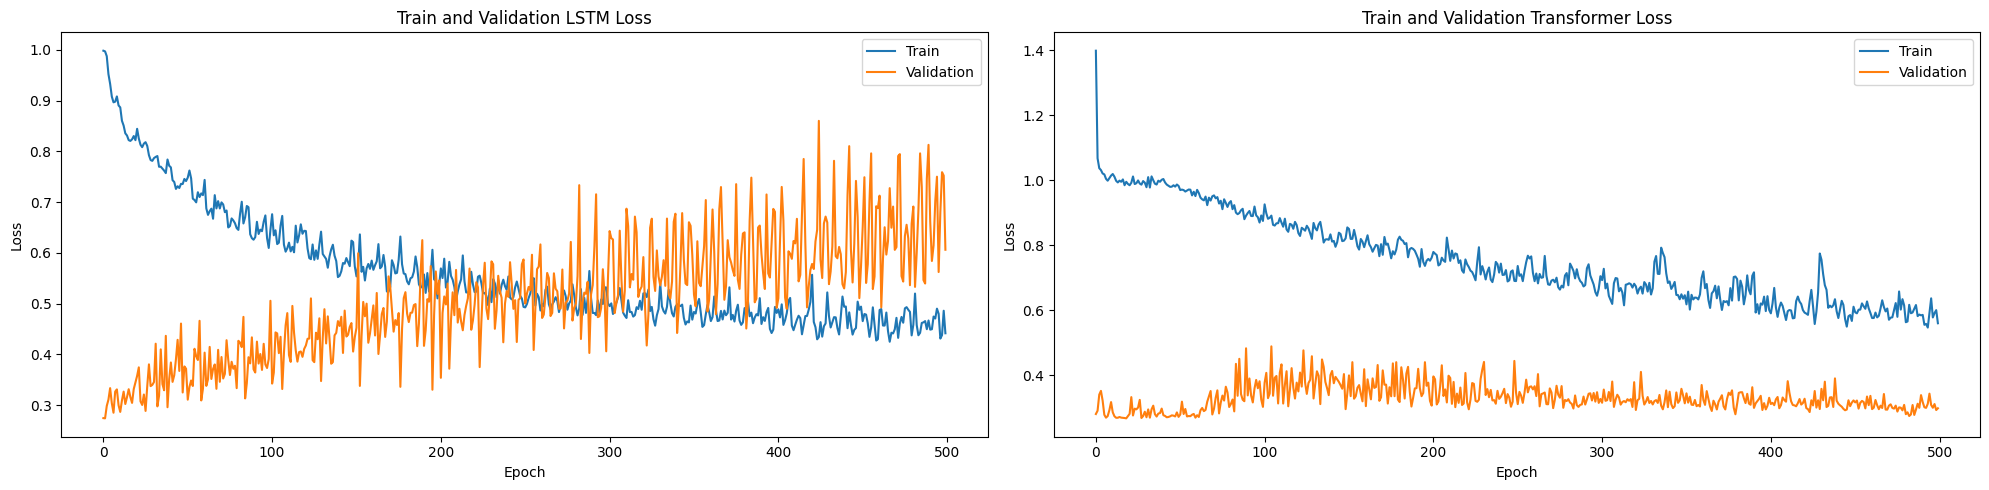

In [11]:
# Plot both lstm and transformer losses (train and validation)
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(lstm_train_loss, label='LSTM Train Loss')
axs[0].plot(lstm_val_loss, label='LSTM Validation Loss')
axs[1].plot(transformer_train_loss, label='Transformer Train Loss')
axs[1].plot(transformer_val_loss, label='Transformer Validation Loss')

# Set the titles
axs[0].set_title('Train and Validation LSTM Loss')
axs[1].set_title('Train and Validation Transformer Loss')

# Set the labels
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')

# Show one legend using [Train, Validation] as labels
axs[0].legend(['Train', 'Validation'])
axs[1].legend(['Train', 'Validation'])

plt.tight_layout()

# Save the plot
plt.savefig(f"plots/{config['task']}/loss_{config['task']}.png")
plt.show()

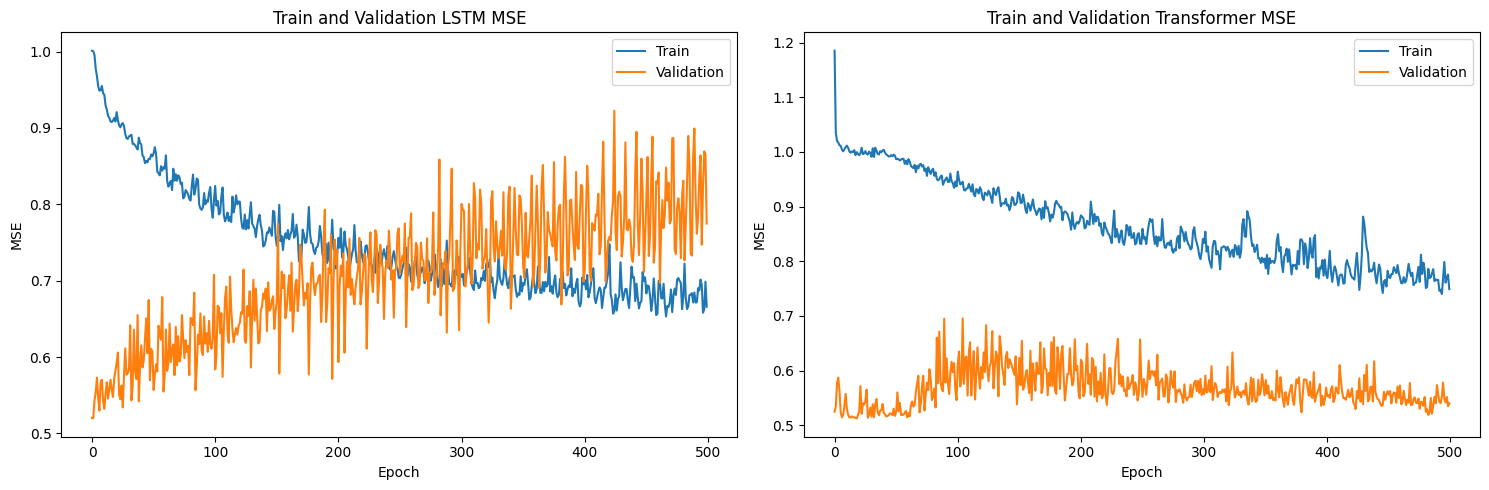

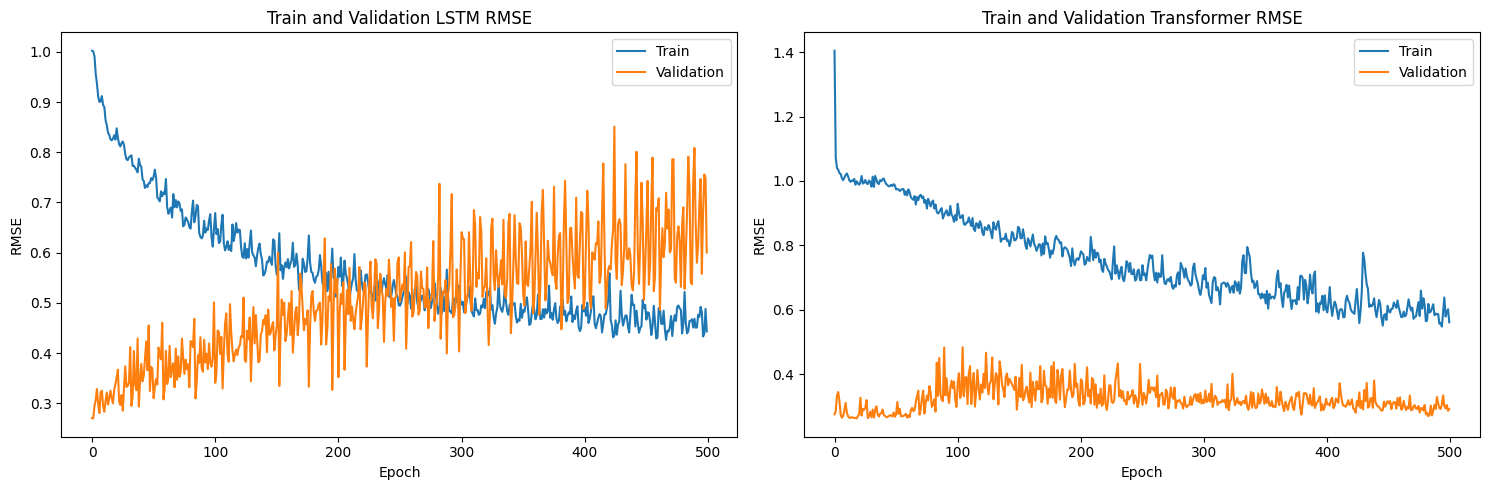

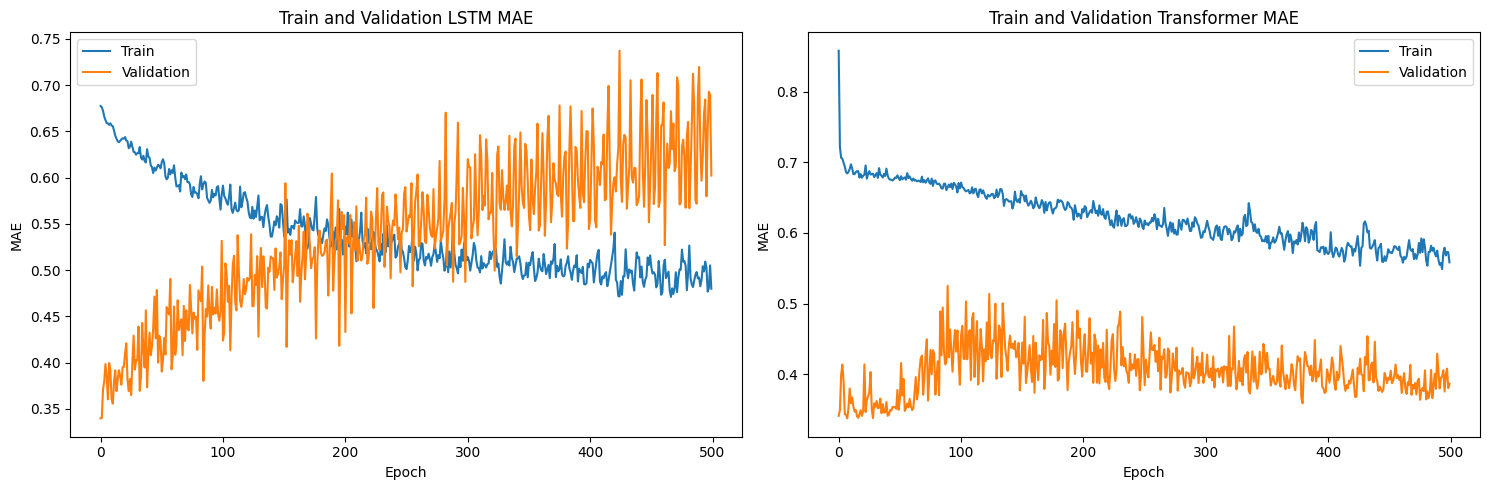

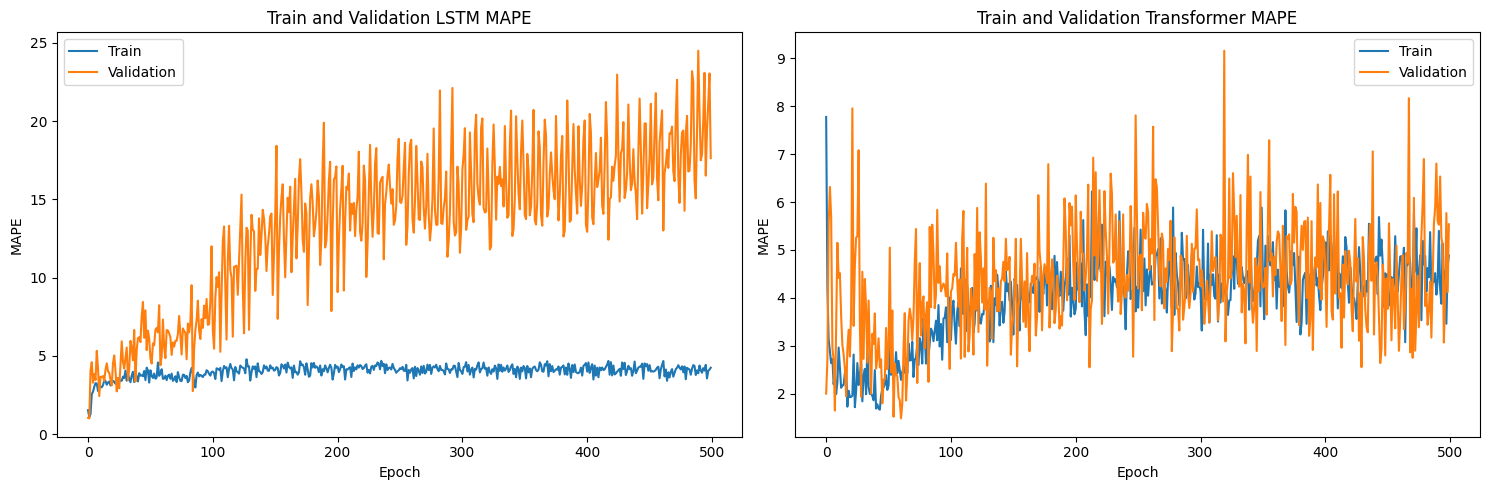

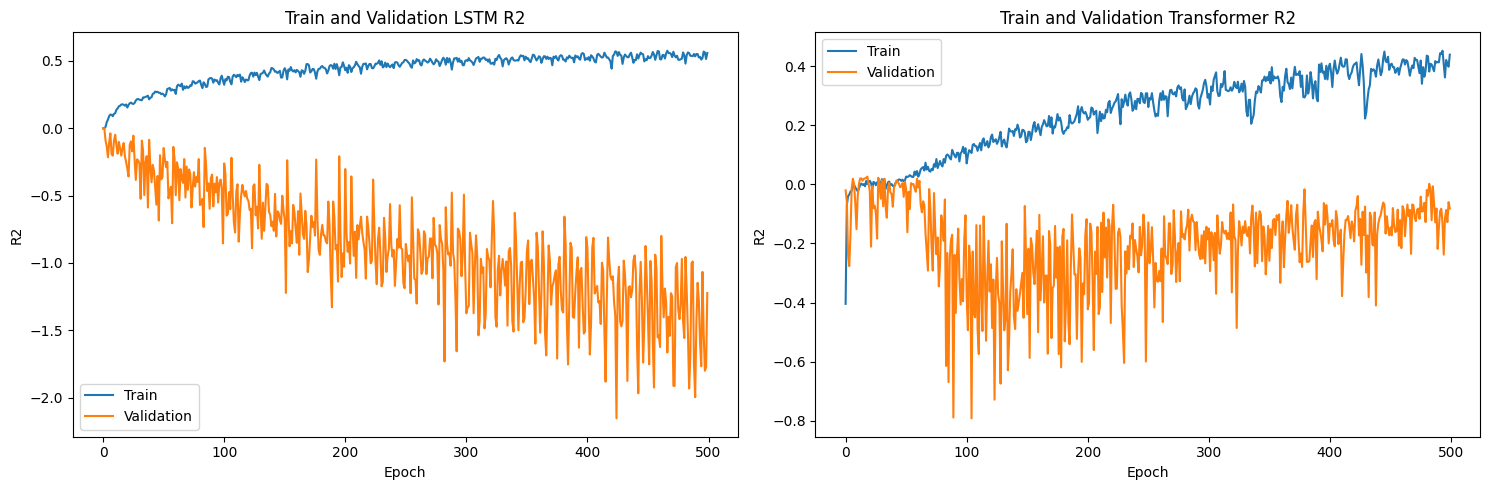

In [12]:
# Plot lstm and transformer metrics (train and validation - classification)
if task == 'classification':
    metrics = [
        ('Accuracy', lstm_train_accuracy, lstm_val_accuracy, transformer_train_accuracy, transformer_val_accuracy),
        ('Precision', lstm_train_precision, lstm_val_precision, transformer_train_precision, transformer_val_precision),
        ('Recall', lstm_train_recall, lstm_val_recall, transformer_train_recall, transformer_val_recall),
        ('F1', lstm_train_f1, lstm_val_f1, transformer_train_f1, transformer_val_f1),
        ('AUROC', lstm_train_auroc, lstm_val_auroc, transformer_train_auroc, transformer_val_auroc)
    ]
else:
    metrics = [
        ('MSE', lstm_train_mse, lstm_val_mse, transformer_train_mse, transformer_val_mse),
        ('RMSE', lstm_train_rmse, lstm_val_rmse, transformer_train_rmse, transformer_val_rmse),
        ('MAE', lstm_train_mae, lstm_val_mae, transformer_train_mae, transformer_val_mae),
        ('MAPE', lstm_train_mape, lstm_val_mape, transformer_train_mape, transformer_val_mape),
        ('R2', lstm_train_r2, lstm_val_r2, transformer_train_r2, transformer_val_r2)
    ]

for i, (metric_name, lstm_train, lstm_val, transformer_train, transformer_val) in enumerate(metrics):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    axs[0].plot(lstm_train, label='LSTM Train')
    axs[0].plot(lstm_val, label='LSTM Validation')
    axs[0].set_title(f'Train and Validation LSTM {metric_name}')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel(metric_name)
    
    axs[1].plot(transformer_train, label='Transformer Train')
    axs[1].plot(transformer_val, label='Transformer Validation')
    axs[1].set_title(f'Train and Validation Transformer {metric_name}')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel(metric_name)
    
    plt.tight_layout()

    # Show one legend using [Train, Validation] as labels
    axs[0].legend(['Train', 'Validation'])
    axs[1].legend(['Train', 'Validation'])
    
    # Save the plot
    plt.savefig(f"plots/{config['task']}/{metric_name.lower()}_{config['task']}_tr_val_metrics.png")
    plt.show()


[('MSE', 1.0812712907791138, 0.7325564026832581), ('RMSE', 1.1691476106643677, 0.5366389155387878), ('MAE', 0.8736685514450073, 0.5422744750976562), ('MAPE', 5.352945804595947, 1.6200106143951416), ('R2', -1.2009787559509277, -0.010249614715576172)]


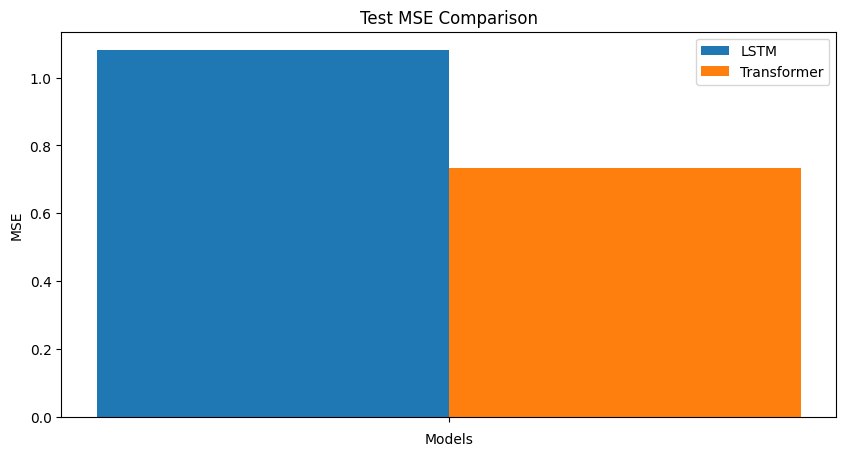

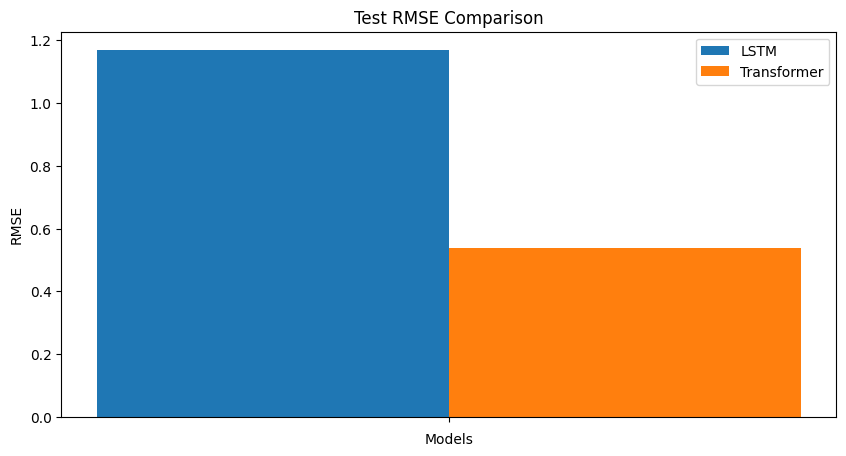

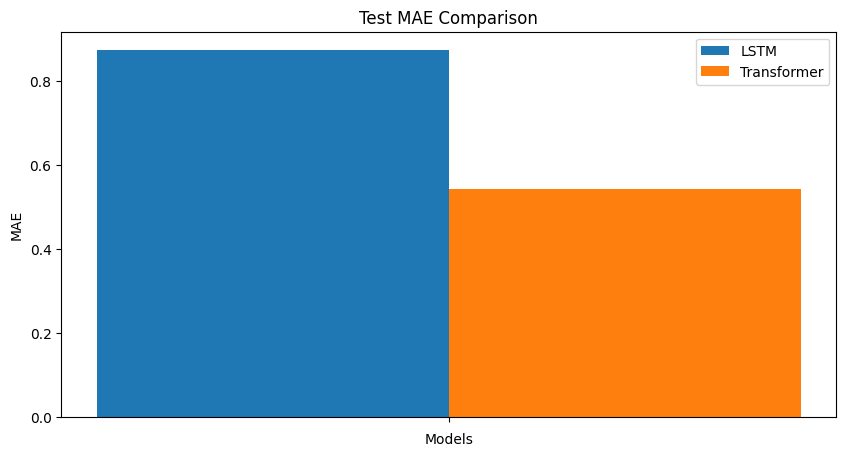

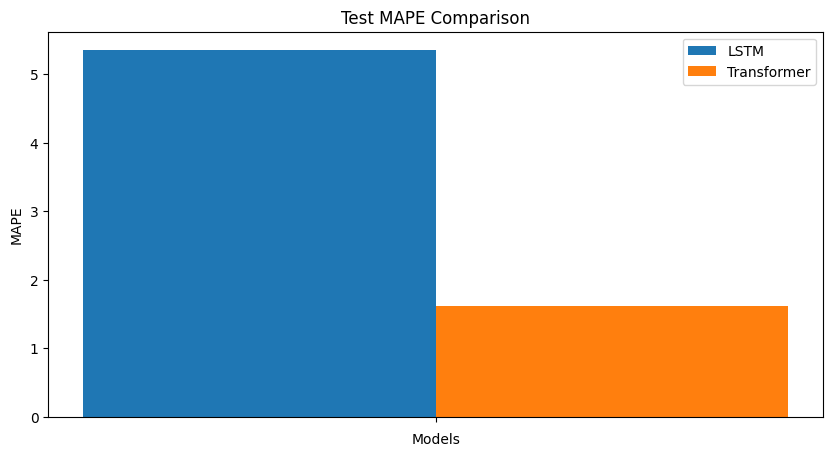

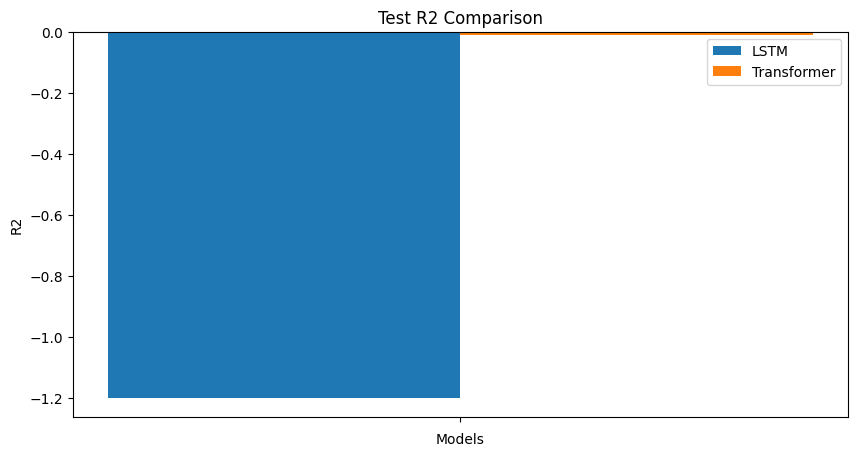

In [13]:
# Plot lstm and transformer metrics (test - classification)
if task == 'classification':
    metrics = [
        ('Accuracy', lstm_test_accuracy, transformer_test_accuracy),
        ('Precision', lstm_test_precision, transformer_test_precision),
        ('Recall', lstm_test_recall, transformer_test_recall),
        ('F1', lstm_test_f1, transformer_test_f1),
    ]
else:
    metrics = [
        ('MSE', lstm_test_mse, transformer_test_mse),
        ('RMSE', lstm_test_rmse, transformer_test_rmse),
        ('MAE', lstm_test_mae, transformer_test_mae),
        ('MAPE', lstm_test_mape, transformer_test_mape),
        ('R2', lstm_test_r2, transformer_test_r2)
    ]

print(metrics)

# Plot the metrics using bar plots
for metric_name, lstm_value, transformer_value in metrics:
    fig, ax = plt.subplots(figsize=(10, 5))
    bar_width = 0.35
    index = range(1)

    # Create bar plots
    bar1 = ax.bar(index, lstm_value, bar_width, label='LSTM')
    bar2 = ax.bar([i + bar_width for i in index], transformer_value, bar_width, label='Transformer')

    # Set the titles and labels
    ax.set_title(f'Test {metric_name} Comparison')
    ax.set_xlabel('Models')
    ax.set_ylabel(metric_name)
    ax.set_xticks([i + bar_width / 2 for i in index])
    ax.set_xticklabels([''])
    ax.legend()

    # Save the plot
    plt.savefig(f"plots/{config['task']}/test_{metric_name.lower()}_comparison_{config['task']}.png")
    plt.show()
